# SSD300 and SSD512 Predictions

In [1]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
import numpy as np
import matplotlib.patches as patches
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from models.keras_ssd512 import ssd_512
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

from extra_files import helper

# from keras.backend.tensorflow_backend import set_session
# import tensorflow as tf
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# set_session(tf.Session(config=config))

Using TensorFlow backend.
/home/aldo/Documents/ssd/data_generator/object_detection_2d_data_generator.py:43: UserWarning: 'BeautifulSoup' module is missing. The XML-parser will be unavailable.
  warnings.warn("'BeautifulSoup' module is missing. The XML-parser will be unavailable.")


## 1. Load a trained SSD

### 1.1. Build the model and load trained weights into it

In [2]:
def load_model(model_path, height, width, coco):
    # 1: Build the Keras model
    K.clear_session() # Clear previous models from memory.

    scales = []
    if coco == True:
        if height == 300:
            scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
        elif height == 512:
            scales = [0.04, 0.1, 0.26, 0.42, 0.58, 0.74, 0.9, 1.06]
    else:
        if height == 300:
            scales = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05]
        elif height == 512:
            scales = [0.07, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05]
        
    if height == 300:
        model = ssd_300(image_size=(height, width, 3),
                        n_classes=20,
                        mode='inference',
                        l2_regularization=0.0005,
                        scales=scales, # The scales for MS COCO are [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
                        aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                                 [1.0, 2.0, 0.5],
                                                 [1.0, 2.0, 0.5]],
                        two_boxes_for_ar1=True,
                        steps=[8, 16, 32, 64, 100, 300],
                        offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                        clip_boxes=False,
                        variances=[0.1, 0.1, 0.2, 0.2],
                        normalize_coords=True,
                        subtract_mean=[123, 117, 104],
                        swap_channels=[2, 1, 0],
                        confidence_thresh=0.15,
                        iou_threshold=0.45,
                        top_k=200,
                        nms_max_output_size=400)
    elif height == 512:
        model = ssd_512(image_size=(height, width, 3),
                n_classes=20,
                mode='inference',
                l2_regularization=0.0005,
                scales=scales, # The scales for MS COCO are [0.04, 0.1, 0.26, 0.42, 0.58, 0.74, 0.9, 1.06]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
               two_boxes_for_ar1=True,
               steps=[8, 16, 32, 64, 128, 256, 512],
               offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
               clip_boxes=False,
               variances=[0.1, 0.1, 0.2, 0.2],
               normalize_coords=True,
               subtract_mean=[123, 117, 104],
               swap_channels=[2, 1, 0],
               confidence_thresh=0.15,
               iou_threshold=0.45,
               top_k=200,
               nms_max_output_size=400)

    # 2: Load the trained weights into the model.
    # TODO: Set the path of the trained weights.
    model.load_weights(model_path, by_name=True)

    # 3: Compile the model so that Keras won't complain the next time you load it.

    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    return model

  ## 2. Load Images

Load some images for which you'd like the model to make predictions.

In [3]:
path_root = '../data-cic/preprocess_data'
path_save = path_root + '/predictions/'
test_images_300 = np.load(path_root + '/images_test_300x300.npy')
test_images_512 = np.load(path_root + '/images_test_512x512.npy')
images_all_300 = np.load(path_root + '/images_all_300x300.npy')
images_all_512 = np.load(path_root + '/images_all_512x512.npy')

## 3. Make predictions

In [4]:
# Pascal voc path models
model_pascal_voc_07_12_300x300 = '../weights/pascal_voc/pascal_voc_07_12_300x300.h5'
model_pascal_voc_07_12_512x512 = '../weights/pascal_voc/pascal_voc_07_12_512x512.h5'
model_pascal_voc_07_plus_12_300x300 = '../weights/pascal_voc/pascal_voc_07_plus_12_300x300.h5'
model_pascal_voc_07_plus_12_512x512 = '../weights/pascal_voc/pascal_voc_07_plus_12_512x512.h5'
model_pascal_voc_07_12_coco_300x300 = '../weights/pascal_voc/pascal_voc_07_12_coco_300x300.h5'
model_pascal_voc_07_12_coco_512x512 = '../weights/pascal_voc/pascal_voc_07_12_coco_512x512.h5'
model_pascal_voc_07_plus_12_coco_300x300 = '../weights/pascal_voc/pascal_voc_07_plus_12_coco_300x300.h5'
model_pascal_voc_07_plus_12_coco_512x512 = '../weights/pascal_voc/pascal_voc_07_plus_12_coco_512x512.h5'

In [5]:
def get_predictions(path_model, batch_size, images_list, size_model, coco=False):
    '''
    Make predictions from a model
    path_model: the path to the weights' model
    batch_size: size of the batch
    images_list: list of images to make predictions
    size_model: input size to the model
    '''
    # Create variable to store predictions
    predictions = np.zeros(shape=(1, 200, 6))
    
    model = load_model(path_model, size_model, size_model, coco)

    for batch in helper.get_batch(batch_size, images_list):
        predictions = np.append(predictions, model.predict(batch), axis=0)
    predictions = predictions[1:] # delete empty item

    clean_pre = helper.clean_predictions(predictions)
    adjust_pre = helper.adjust_predictions(clean_pre)
    print('finished', path_model)
    
    # Clean memory
    K.clear_session()
    
    return adjust_pre

In [6]:
# Make predictions of the models
batch_size_300 = 16
batch_size_512 = 16

# PASCAL predictions
# 07+12
# pred_voc_07_12_300x300_test = get_predictions(model_pascal_voc_07_12_300x300, batch_size_300, test_images_300, 300)
# np.save(path_save + 'pred_voc_07_12_300x300_test', pred_voc_07_12_300x300_test)
# pred_voc_07_12_300x300_all = get_predictions(model_pascal_voc_07_12_300x300, batch_size_300, images_all_300, 300)
# np.save(path_save + 'pred_voc_07_12_300x300_all', pred_voc_07_12_300x300_all)
# pred_voc_07_12_512x512_test = get_predictions(model_pascal_voc_07_12_512x512, batch_size_512, test_images_512, 512)
# np.save(path_save + 'pred_voc_07_12_512x512_test', pred_voc_07_12_512x512_test)
# pred_voc_07_12_512x512_all = get_predictions(model_pascal_voc_07_12_512x512, batch_size_512, images_all_512, 512)
# np.save(path_save + 'pred_voc_07_12_512x512_all', pred_voc_07_12_512x512_all)

# 07++12
# pred_voc_07_plus_12_300x300_test = get_predictions(model_pascal_voc_07_plus_12_300x300, batch_size_300, test_images_300, 300)
# np.save(path_save + 'pred_voc_07_plus_12_300x300_test', pred_voc_07_plus_12_300x300_test)
# pred_voc_07_plus_12_300x300_all = get_predictions(model_pascal_voc_07_plus_12_300x300, batch_size_300, images_all_300, 300)
# np.save(path_save + 'pred_voc_07_plus_12_300x300_all', pred_voc_07_plus_12_300x300_all)
# pred_voc_07_plus_12_512x512_test = get_predictions(model_pascal_voc_07_plus_12_512x512, batch_size_512, test_images_512, 512)
# np.save(path_save + 'pred_voc_07_plus_12_512x512_test', pred_voc_07_plus_12_512x512_test)
# pred_voc_07_plus_12_512x512_all = get_predictions(model_pascal_voc_07_plus_12_512x512, batch_size_512, images_all_512, 512)
# np.save(path_save + 'pred_voc_07_plus_12_512x512_all', pred_voc_07_plus_12_512x512_all)

# 07+12+COCO
# pred_voc_07_12_coco_300x300_test = get_predictions(model_pascal_voc_07_12_coco_300x300, batch_size_300, test_images_300, 300, True)
# np.save(path_save + 'pred_voc_07_12_coco_300x300_test', pred_voc_07_12_coco_300x300_test)
# pred_voc_07_12_coco_300x300_all = get_predictions(model_pascal_voc_07_12_coco_300x300, batch_size_300, images_all_300, 300, True)
# np.save(path_save + 'pred_voc_07_12_coco_300x300_all', pred_voc_07_12_coco_300x300_all)
# pred_voc_07_12_coco_512x512_test = get_predictions(model_pascal_voc_07_12_coco_512x512, batch_size_512, test_images_512, 512, True)
# np.save(path_save + 'pred_voc_07_12_coco_512x512_test', pred_voc_07_12_coco_512x512_test)
# pred_voc_07_12_coco_512x512_all = get_predictions(model_pascal_voc_07_12_coco_512x512, batch_size_512, images_all_512, 512, True)
# np.save(path_save + 'pred_voc_07_12_coco_512x512_all', pred_voc_07_12_coco_512x512_all)

# 07++12+COCO
# pred_voc_07_plus_12_coco_300x300_test = get_predictions(model_pascal_voc_07_plus_12_coco_300x300, batch_size_300, test_images_300, 300, True)
# np.save(path_save + 'pred_voc_07_plus_12_coco_300x300_test', pred_voc_07_plus_12_coco_300x300_test)
# pred_voc_07_plus_12_coco_300x300_all = get_predictions(model_pascal_voc_07_plus_12_coco_300x300, batch_size_300, images_all_300, 300, True)
# np.save(path_save + 'pred_voc_07_plus_12_coco_300x300_all', pred_voc_07_plus_12_coco_300x300_all)
# pred_voc_07_plus_12_coco_512x512_test = get_predictions(model_pascal_voc_07_plus_12_coco_512x512, batch_size_512, test_images_512, 512, True)
# np.save(path_save + 'pred_voc_07_plus_12_coco_512x512_test', pred_voc_07_plus_12_coco_512x512_test)
# pred_voc_07_plus_12_coco_512x512_all = get_predictions(model_pascal_voc_07_plus_12_coco_512x512, batch_size_512, images_all_512, 512, True)
# np.save(path_save + 'pred_voc_07_plus_12_coco_512x512_all', pred_voc_07_plus_12_coco_512x512_all)

finished ../weights/pascal_voc/pascal_voc_07_plus_12_coco_512x512.h5
finished ../weights/pascal_voc/pascal_voc_07_plus_12_coco_512x512.h5


In [7]:
pred = helper.get_coordinates(pred_voc_07_plus_12_coco_512x512_all)
pred = helper.normilize_to_pixel(pred, 512, 512)

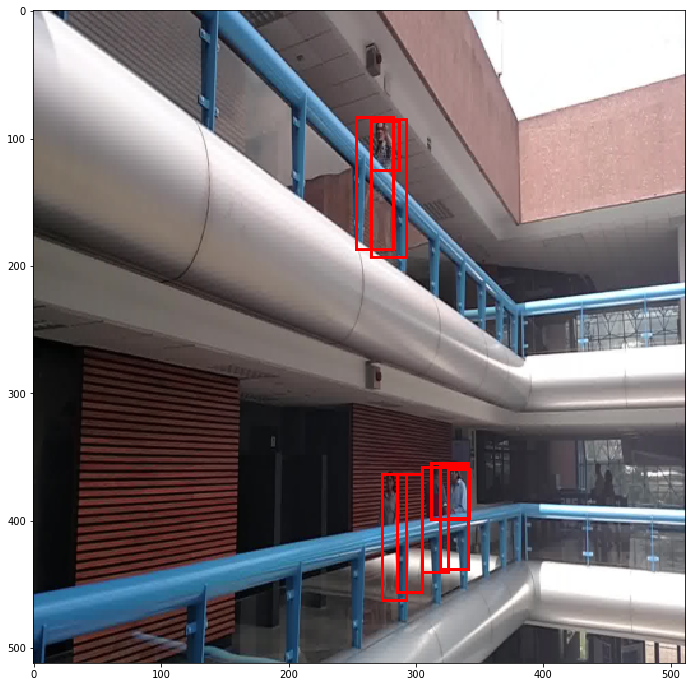

In [8]:
helper.show_image_bb(images_all_512[0], pred[0])